In [1]:
from __future__ import print_function
import pickle 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from sub import subMNIST
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
%matplotlib inline

Files already downloaded
3000
750


In [2]:
#Set labels to zeros as a dummy values to make the train_loader work 

trainset_unlabeled = pickle.load(open("train_unlabeled.p", "rb")) 
trainset_unlabeled.train_labels = torch.zeros(trainset_unlabeled.train_data.size(0))
train_loader  = torch.utils.data.DataLoader(trainset_unlabeled, batch_size=64, shuffle=True, num_workers=2)

validset = pickle.load(open("validation.p", "rb"))
valid_loader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True, num_workers=2)

In [3]:
#Model Architecture

encoder = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(1, 16, kernel_size=3)), 
          ('relu1', nn.ReLU()),
          
          ('conv2', nn.Conv2d(16, 8, kernel_size=3)),
          ('relu2', nn.ReLU()),
          
          ('conv3', nn.Conv2d(8, 8, kernel_size=3)),
          ('relu3', nn.ReLU()),
        ]))

decoder = nn.Sequential(OrderedDict([
          ('conv1', nn.ConvTranspose2d(8, 8, kernel_size=3)), 
          ('relu1', nn.ReLU()),
          
          ('conv2', nn.ConvTranspose2d(8, 16, kernel_size=3)),
          ('relu2', nn.ReLU()),
          
          ('conv3', nn.ConvTranspose2d(16, 1, kernel_size=3)),
          ('relu3', nn.ReLU()),
          ('sigmoid4', nn.Sigmoid())
            
        ]))

model =  nn.Sequential(OrderedDict([
          ('encoder', encoder),
          ('decoder', decoder),
        ]))

In [4]:
model 

Sequential (
  (encoder): Sequential (
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU ()
    (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU ()
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (relu3): ReLU ()
  )
  (decoder): Sequential (
    (conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU ()
    (conv2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU ()
    (conv3): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
    (relu3): ReLU ()
    (sigmoid4): Sigmoid ()
  )
)

In [5]:
# Measuring the error of a reconstruction with BCE Loss which is usually used for autoencoders 
# BCE Loss requires the "targert" and "data" to be an output btw 0 and 1
# Therefore, we usually call sigmoid on the target before wrapping it into a Variable

loss_function = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
def train(epoch):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):

        target = Variable(F.sigmoid(data))
        data = Variable(data)  
        optimizer.zero_grad() 
        output = model(data) 
        loss = loss_function(output, target) 
        loss.backward() 
        optimizer.step()
        if batch_idx % 40 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0])) 

In [7]:
def test(epoch, valid_loader):
    loss = 0
    for data, _ in valid_loader:
        target = Variable(F.sigmoid(data))
        data = Variable(data, volatile=True)
        output = model(data)
        loss += loss_function(output, target)
    print(loss) 

In [8]:
for epoch in range(1, 2):
    train(epoch)
    test(epoch, valid_loader)

Train Epoch: 1 [0/47000 (0%)]	Loss: 0.696046
Train Epoch: 1 [2560/47000 (5%)]	Loss: 0.641720
Train Epoch: 1 [5120/47000 (11%)]	Loss: 0.637229
Train Epoch: 1 [7680/47000 (16%)]	Loss: 0.643380
Train Epoch: 1 [10240/47000 (22%)]	Loss: 0.637016
Train Epoch: 1 [12800/47000 (27%)]	Loss: 0.635693
Train Epoch: 1 [15360/47000 (33%)]	Loss: 0.637547
Train Epoch: 1 [17920/47000 (38%)]	Loss: 0.639174
Train Epoch: 1 [20480/47000 (44%)]	Loss: 0.637057
Train Epoch: 1 [23040/47000 (49%)]	Loss: 0.637271
Train Epoch: 1 [25600/47000 (54%)]	Loss: 0.639867
Train Epoch: 1 [28160/47000 (60%)]	Loss: 0.632279
Train Epoch: 1 [30720/47000 (65%)]	Loss: 0.638465
Train Epoch: 1 [33280/47000 (71%)]	Loss: 0.635516
Train Epoch: 1 [35840/47000 (76%)]	Loss: 0.637575
Train Epoch: 1 [38400/47000 (82%)]	Loss: 0.634690
Train Epoch: 1 [40960/47000 (87%)]	Loss: 0.638334
Train Epoch: 1 [43520/47000 (93%)]	Loss: 0.635539
Train Epoch: 1 [46080/47000 (98%)]	Loss: 0.638768
Variable containing:
 99.8431
[torch.FloatTensor of size 1]

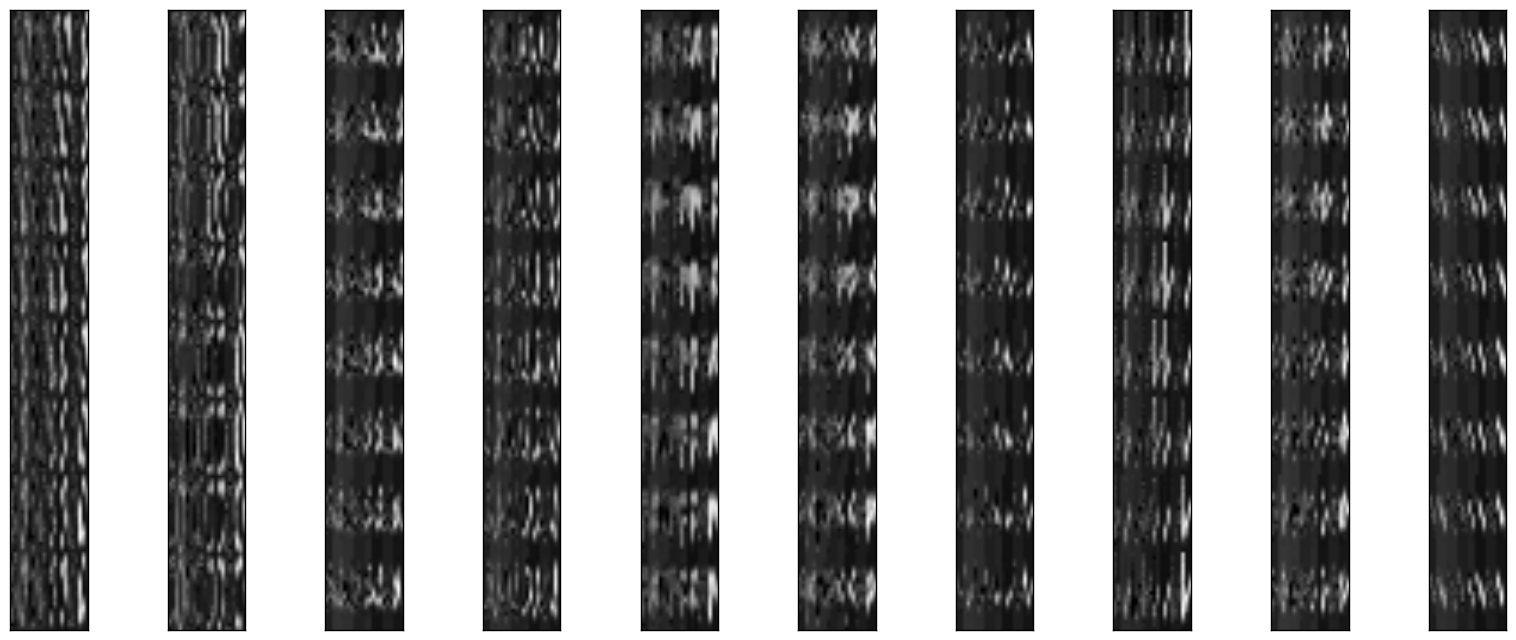

In [10]:
# Encoder Test_drive: visualizing the latent space 

dataiter = iter(valid_loader) 
data, _ = dataiter.next()
output = encoder(Variable(data))

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(output.data[i].numpy().reshape(22, 22 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

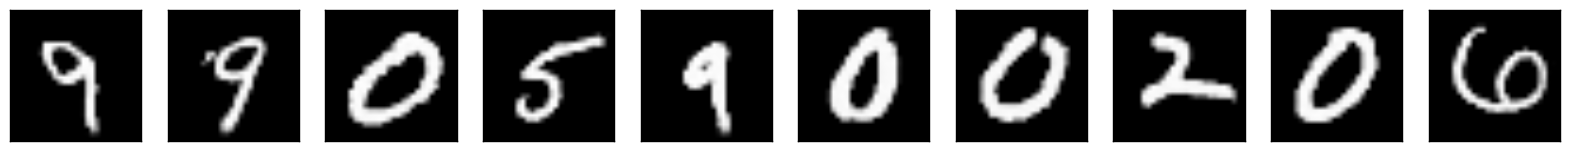

In [11]:
# Model Test_Drive: Reconstructing/Generating images  

dataiter = iter(valid_loader) 
data, _ = dataiter.next()
output = model(Variable(data))

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(output[i].data.view(28, 28).numpy())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
